In [150]:
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools
from tqdm import tqdm

#### ついにSNNモデルで学習を進める
- SNNはその性質から時系列データなのでRNNよろしく時系列に置き換えて学習させる
<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial5/unrolled_2.png?raw=true' width="800">
</center>

以下の数式をヘビサイドステップ関数を使って定式化すると

$$S[t] = \begin{cases} 1, &\text{if}~U[t] > U_{\rm thr} \\
0, &\text{otherwise}\end{cases} \tag{2}$$

$$S[t] = \Theta(U[t] - U_{\rm thr}) \tag{3}$$ 

where $\Theta(\cdot)$ is the Heaviside step function:

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial3/3_2_spike_descrip.png?raw=true' width="600">
</center>



- forwardとbackwardの関係については以下のようになる
- S[t]に関しては傾きは０か∞しか値を取り得ない
<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial5/non-diff.png?raw=true' width="400">
</center>

- 一方でヘビサイド関数の微分はディラックのデルタ関数であるが<br>
１地点で値が∞その他では０であり、勾配消失につながる

その問題を解消するために、導関数を以下の式に置き換えて学習させる


$$ \frac{\partial \tilde{S}}{\partial U} \leftarrow \frac{1}{\pi}\frac{1}{(1+[U\pi]^2)} \tag{5}$$

また、全体の勾配情報は以下の式で表される
$$\frac{\partial \mathcal{L}}{\partial W} = 
\frac{\partial \mathcal{L}}{\partial S}
\underbrace{\frac{\partial S}{\partial U}}_{\{0, \infty\}}
\frac{\partial U}{\partial I}\
\frac{\partial I}{\partial W}\ \tag{4}$$


In [151]:
class LeakySurrogate(nn.Module):
    def __init__(self,beta,threshold=1):
        super(LeakySurrogate,self).__init__()

        self.beta=beta
        self.threshold=threshold
        self.spike_gradient=self.Atan.apply
    
    def forward(self,input_,mem):
        spk=self.spike_gradient((mem-self.threshold))
        reset=(self.beta * spk * self.threshold).detach()
        mem=self.beta*mem+input_ - reset
        return spk,mem
    
    @staticmethod
    class Atan(torch.autograd.Function):
        @staticmethod
        def forward(ctx,mem):
            spk=(mem >0).float()
            ctx.save_for_backward(mem)
            return spk
        
        @staticmethod
        def backward(ctx,grad_output):
            (mem,)=ctx.saved_tensors
            grad=1/(1+(np.pi * mem).pow_2(2)) * grad_output
            return grad

を実装するコードが以下の一行にまとめられている

In [152]:
lif1=LeakySurrogate(beta=0.9)

#### 予測クラスの選定の仕方
- Rate Coding : 最も高い発火率のものを予測クラスにする
- Latency Coding : 最初に発火するニューロンを予測クラスにする

以下の式のようにソフトマックスを取ることで、正解のラベルはより発火し<br>
不正解のラベルは発火しないことになる

$$p_i[t] = \frac{e^{U_i[t]}}{\sum_{j=0}^{C}e^{U_j[t]}} \tag{8}$$


In [153]:
batch_size=128
data_path='data/MNIST'

device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [154]:
transform=transforms.Compose([
    transforms.Resize((28,28)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0,),(1,))
])

mnist_train=datasets.MNIST(data_path,train=True,download=True,transform=transform)
mnist_test=datasets.MNIST(data_path,train=False,download=True,transform=transform)

In [155]:
train_dataset, val_dataset = torch.utils.data.random_split(mnist_train, [len(mnist_train)-10000, 10000])
train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True,drop_last=True)
valid_loader=DataLoader(val_dataset,batch_size=batch_size,shuffle=True,drop_last=True)
test_loader=DataLoader(mnist_test,batch_size=batch_size,shuffle=True,drop_last=True)

In [156]:
num_inputs=28*28
num_hidden=1000
num_outputs=10

num_steps=200
beta=0.95

- fc1 : MNISTからの入力を線形変換する
- lif1 : 重み付けされた入力を時間で積分して、閾値を超えたらスパイクを出す
- fc2 : lif1からのスパイクを線形変換する
- lif2 : これまでのものを時間で積分して、閾値を超えたらスパイクを出す

In [157]:
class SNNNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1=nn.Linear(num_inputs,num_hidden)
        self.lif1=snn.Leaky(beta=beta)
        self.fc2=nn.Linear(num_hidden,num_outputs)
        self.lif2=snn.Leaky(beta=beta)

    def forward(self,x):
        mem1=self.lif1.init_leaky()
        mem2=self.lif2.init_leaky()

        spk2_rec=[]
        mem2_rec=[]

        for step in range(num_steps):
            cur1=self.fc1(x)
            spk1,mem1=self.lif1(cur1,mem1)
            cur2=self.fc2(spk1)
            spk2,mem2=self.lif2(cur2,mem2)

            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec,dim=0), torch.stack(mem2_rec,dim=0)
    
net=SNNNet().to(device)



In [158]:
def print_batch_accuracy(data,targets,train=False):
    output,_=net(data.view(batch_size,-1))
    #出力のうちmem_recの方は計算に使わないので_として使わないことを明示
    _, idx=output.sum(dim=0).max(1)
    #max(1)でdim方向のうちmaxの値のインデックスを返す
    acc=np.mean((targets==idx).detach().cpu().numpy())

    if train:
        print(f'Train Accuracy : {acc*100:.2f}%')
    else:
        print(f'valid Accuracy : {acc*100:.2f}%')

def train_printer(
        data,targets,epoch,
        counter,iter_counter,loss_hist,
        valid_loss_hist,valid_data,valid_targets):
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"valid Set Loss: {valid_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(valid_data, valid_targets, train=False)
    print("\n")

In [159]:
loss=nn.CrossEntropyLoss()

optimizer=torch.optim.Adam(net.parameters(),lr=5e-4,betas=(0.9,0.999))

In [160]:
num_epochs = 10
loss_hist = []
valid_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)
    
    with tqdm(train_loader) as pbar:
        pbar.set_description(f'[Epoch]:{epoch+1}/{num_epochs}')
    # Minibatch training loop
        for data, targets in train_batch:
            data = data.to(device)
            targets = targets.to(device)

            # forward pass
            net.train()
            spk_rec, mem_rec = net(data.view(batch_size, -1))

            # initialize the loss & sum over time
            loss_val = torch.zeros((1), device=device)
            for step in range(num_steps):
                loss_val += loss(mem_rec[step], targets)

            # Gradient calculation + weight update
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            # Store loss history for future plotting
            loss_hist.append(loss_val.item())


            # Test set
            with torch.no_grad():
                net.eval()
                valid_data, valid_targets = next(iter(valid_loader))
                valid_data = valid_data.to(device)
                valid_targets = valid_targets.to(device)

                # Test set forward pass
                valid_spk, valid_mem = net(valid_data.view(batch_size, -1))

                # Test set loss
                valid_loss = torch.zeros((1), device=device)
                for step in range(num_steps):
                    valid_loss += loss(valid_mem[step], valid_targets)
                valid_loss_hist.append(valid_loss.item())


                # Print train/test loss/accuracy
                if counter % 50 == 0:
                    train_printer(
                        data, targets, epoch,
                        counter, iter_counter,
                        loss_hist, valid_loss_hist,
                        valid_data, valid_targets)
                counter += 1
                iter_counter +=1

[Epoch]:1/10:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 0, Iteration 0
Train Set Loss: 515.10
valid Set Loss: 388.42
Train Accuracy : 55.47%
valid Accuracy : 34.38%


Epoch 0, Iteration 50
Train Set Loss: 89.62
valid Set Loss: 161.42
Train Accuracy : 85.16%
valid Accuracy : 92.97%


Epoch 0, Iteration 100
Train Set Loss: 134.03
valid Set Loss: 74.08
Train Accuracy : 88.28%
valid Accuracy : 86.72%


Epoch 0, Iteration 150
Train Set Loss: 88.20
valid Set Loss: 84.69
Train Accuracy : 90.62%
valid Accuracy : 93.75%


Epoch 0, Iteration 200
Train Set Loss: 33.85
valid Set Loss: 81.25
Train Accuracy : 92.97%
valid Accuracy : 93.75%


Epoch 0, Iteration 250
Train Set Loss: 69.85
valid Set Loss: 88.73
Train Accuracy : 90.62%
valid Accuracy : 90.62%


Epoch 0, Iteration 300
Train Set Loss: 80.23
valid Set Loss: 35.44
Train Accuracy : 95.31%
valid Accuracy : 96.09%


Epoch 0, Iteration 350
Train Set Loss: 30.21
valid Set Loss: 53.63
Train Accuracy : 92.19%
valid Accuracy : 92.97%




[Epoch]:2/10:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 1, Iteration 10
Train Set Loss: 58.03
valid Set Loss: 49.43
Train Accuracy : 93.75%
valid Accuracy : 95.31%


Epoch 1, Iteration 60
Train Set Loss: 28.51
valid Set Loss: 73.04
Train Accuracy : 93.75%
valid Accuracy : 95.31%


Epoch 1, Iteration 110
Train Set Loss: 23.04
valid Set Loss: 38.82
Train Accuracy : 97.66%
valid Accuracy : 95.31%


Epoch 1, Iteration 160
Train Set Loss: 30.00
valid Set Loss: 58.48
Train Accuracy : 97.66%
valid Accuracy : 93.75%


Epoch 1, Iteration 210
Train Set Loss: 17.23
valid Set Loss: 25.09
Train Accuracy : 96.88%
valid Accuracy : 94.53%




[Epoch]:2/10:   0%|          | 0/390 [01:13<?, ?it/s]


KeyboardInterrupt: 

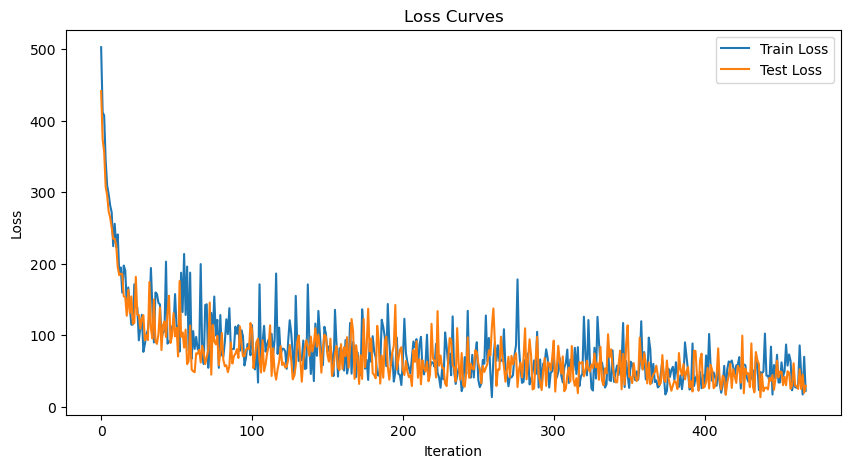

In [ ]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [ ]:
total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)
    
    # forward pass
    test_spk, _ = net(data.view(data.size(0), -1))

    # calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 9429/10000
Test Set Accuracy: 94.29%
